# Some import

In [1]:
import os
import sys
sys.path.append(os.path.realpath(".."))

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from evlp_bronch.dataset import ALL_LUNG_IDS, RawEVLPDataset, ProcessedEVLPDataset

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import numpy as np
import tqdm as tqdm

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv1D, MaxPooling1D, Concatenate

device = torch.device("mps")

# Load Data

In [2]:
train_lung_ids, test_lung_ids = train_test_split(
    ALL_LUNG_IDS, test_size=2, random_state=0
)
train_lung_ids, val_lung_ids = train_test_split(
    train_lung_ids, test_size=2, random_state=0
)
# Splits result should be deterministic
assert set(val_lung_ids) == {8, 606}, str(val_lung_ids)
assert set(test_lung_ids) == {615, 731}, str(test_lung_ids)

train_dataset = ProcessedEVLPDataset(train_lung_ids)
val_dataset = ProcessedEVLPDataset(val_lung_ids)
test_dataset = ProcessedEVLPDataset(test_lung_ids)

In [3]:
len(train_dataset), len(val_dataset), len(test_dataset)

(136, 4, 6)

# Data Visualization

In [4]:
for i in range(len(train_dataset)):
    if train_dataset[i]['Lung_id'] == 6:
        tmp = train_dataset[i+2]
        break

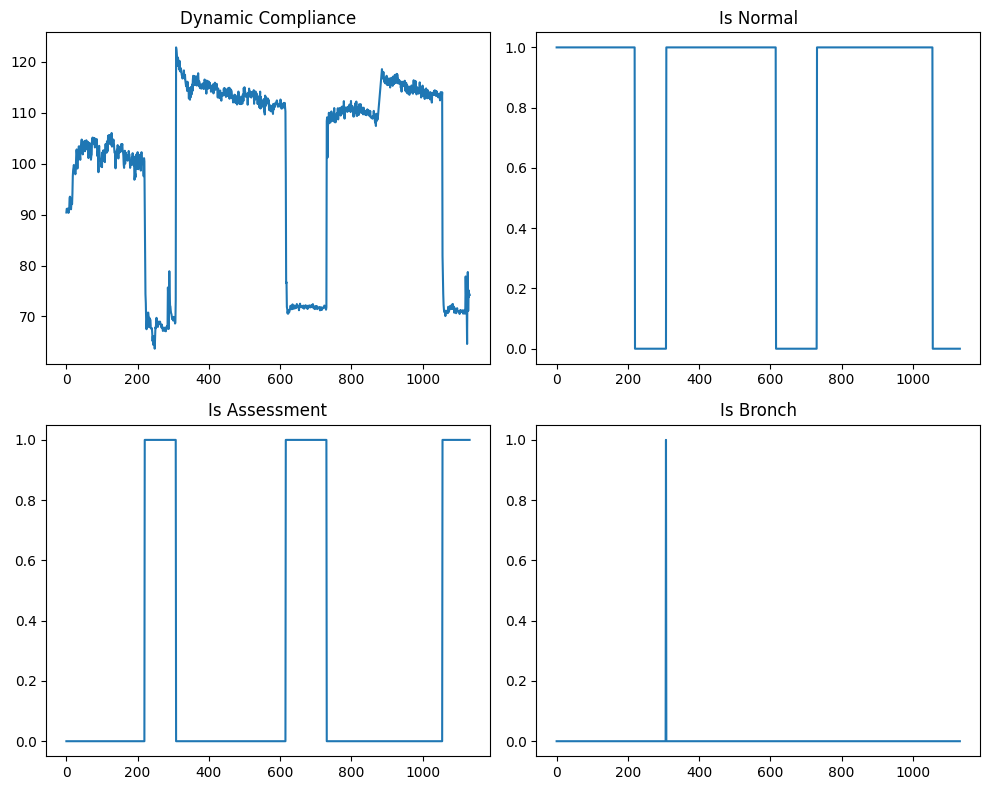

In [5]:
a = val_dataset[0]['Dy_comp']
c = val_dataset[0]['Is_normal']
b = val_dataset[0]['Is_assessment']
d = val_dataset[0]['Is_bronch']

plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.title('Dynamic Compliance')
plt.plot(a)

plt.subplot(2, 2, 2)
plt.title('Is Normal')
plt.plot(c)

plt.subplot(2, 2, 3)
plt.title('Is Assessment')
plt.plot(b)

plt.subplot(2, 2, 4)
plt.title('Is Bronch')
plt.plot(d)

plt.tight_layout()

# Utils Functions

In [6]:
def rindex(lst, value): # find the last occurence of a value in a list
    lst.reverse()
    i = lst.index(value)
    lst.reverse()
    return len(lst) - i - 1

In [7]:
def center_pad_sequence(sequence, target_length): # centre pad with same value
        current_length = len(sequence)
        total_padding = target_length - current_length
        if total_padding <= 0:
            return sequence

        pad_before = total_padding // 2
        pad_after = total_padding - pad_before

        return np.pad(sequence, (pad_before, pad_after), mode='edge')
len(center_pad_sequence(train_dataset[0]['Is_bronch'][:1+1], 1470))

1470

# Set dataset

In [8]:
X_dc = []
X_is_normal = []
X_is_bronch = []
X_is_assess = []

Y = []

for i in train_dataset:
    metric_start = rindex(list(i['Is_bronch']), 1) # find the last bronch
    changes = np.where(np.diff(i['Is_assessment']) == 1)[0] # find the last assessment period begins
    last_assessment_start = changes[-1] + 1 if len(changes) > 0 else len(i['Is_assessment']) - 1

    if metric_start < (len(i['Is_assessment']) - 1) * 0:
        continue

    if metric_start > last_assessment_start: # if bronch后面没有assessment
        last_assessment_start = len(i['Is_assessment']) - 1
    if len(i['Dy_comp'][metric_start:last_assessment_start]) == 0: # if bronch紧接着assessment
        continue

    # 做padding，保证长度一致，用最长的长度
    X_dc.append(center_pad_sequence(i['Dy_comp'][:metric_start+1], 1470))
    X_is_normal.append(center_pad_sequence(i['Is_normal'][:metric_start+1], 1470))
    X_is_assess.append(center_pad_sequence(i['Is_assessment'][:metric_start+1],1470))
    X_is_bronch.append(center_pad_sequence(i['Is_bronch'][:metric_start+1], 1470))

    Y.append(center_pad_sequence(i['Dy_comp'][metric_start:last_assessment_start], 1054))

print(f"length is {len(X_dc)}")    
assert len(X_dc) == len(X_is_assess) == len(X_is_bronch) == len(X_is_normal) == len(Y), "Inconsistent number of samples"

X_dc = np.array(X_dc).reshape(-1, 1470)
X_is_normal = np.array(X_is_normal).reshape(-1, 1470)
X_is_bronch = np.array(X_is_bronch).reshape(-1, 1470)
X_is_assess = np.array(X_is_assess).reshape(-1, 1470)
Y = torch.from_numpy(np.array(Y)).float()

length is 118


In [9]:
X_dc_val = []
X_is_normal_val = []
X_is_bronch_val = []
X_is_assess_val = []

Y_val = []

for i in val_dataset:
    metric_start = rindex(list(i['Is_bronch']), 1) # find the last bronch
    changes = np.where(np.diff(i['Is_assessment']) == 1)[0] # find the last assessment period begins
    last_assessment_start = changes[-1] + 1 if len(changes) > 0 else len(i['Is_assessment']) - 1

    if metric_start < (len(i['Is_assessment']) - 1) * 0:
        continue

    if metric_start > last_assessment_start: # if bronch后面没有assessment
        last_assessment_start = len(i['Is_assessment']) - 1
    if len(i['Dy_comp'][metric_start:last_assessment_start]) == 0: # if bronch紧接着assessment
        continue

    # 做padding，保证长度一致，用最长的长度
    X_dc_val.append(center_pad_sequence(i['Dy_comp'][:metric_start+1], 1470))
    X_is_normal_val.append(center_pad_sequence(i['Is_normal'][:metric_start+1], 1470))
    X_is_bronch_val.append(center_pad_sequence(i['Is_assessment'][:metric_start+1],1470))
    X_is_assess_val.append(center_pad_sequence(i['Is_bronch'][:metric_start+1], 1470))

    Y_val.append(center_pad_sequence(i['Dy_comp'][metric_start:last_assessment_start], 1054))

print(f"length is {len(X_dc_val)}") 
assert len(X_dc_val) == len(X_is_normal_val) == len(X_is_bronch_val) == len(X_is_assess_val) == len(Y_val), "Inconsistent number of samples" 
X_dc_val = np.array(X_dc_val).reshape(-1, 1470)
X_is_normal_val = np.array(X_is_normal_val).reshape(-1, 1470)
X_is_bronch_val = np.array(X_is_bronch_val).reshape(-1, 1470)
X_is_assess_val = np.array(X_is_assess_val).reshape(-1, 1470)
Y_val = torch.from_numpy(np.array(Y_val)).float()

length is 4


In [10]:
X_dc_test = []
X_is_normal_test = []
X_is_bronch_test = []
X_is_assess_test = []

Y_test = []

for i in test_dataset:
    metric_start = rindex(list(i['Is_bronch']), 1) # find the last bronch
    changes = np.where(np.diff(i['Is_assessment']) == 1)[0] # find the last assessment period begins
    last_assessment_start = changes[-1] + 1 if len(changes) > 0 else len(i['Is_assessment']) - 1

    if metric_start < (len(i['Is_assessment']) - 1) * 0:
        continue

    if metric_start > last_assessment_start: # if bronch后面没有assessment
        last_assessment_start = len(i['Is_assessment']) - 1
    if len(i['Dy_comp'][metric_start:last_assessment_start]) == 0: # if bronch紧接着assessment
        continue

    # 做padding，保证长度一致，用最长的长度
    X_dc_test.append(center_pad_sequence(i['Dy_comp'][:metric_start+1], 1470))
    X_is_normal_test.append(center_pad_sequence(i['Is_normal'][:metric_start+1], 1470))
    X_is_bronch_test.append(center_pad_sequence(i['Is_assessment'][:metric_start+1],1470))
    X_is_assess_test.append(center_pad_sequence(i['Is_bronch'][:metric_start+1], 1470))

    Y_test.append(center_pad_sequence(i['Dy_comp'][metric_start:last_assessment_start], 1054))

print(f"length is {len(X_dc_test)}") 
assert len(X_dc_test) == len(X_is_normal_test) == len(X_is_bronch_test) == len(X_is_assess_test) == len(Y_test), "Inconsistent number of samples" 
X_dc_test = np.array(X_dc_test).reshape(-1, 1470)
X_is_normal_test = np.array(X_is_normal_test).reshape(-1, 1470)
X_is_bronch_test = np.array(X_is_bronch_test).reshape(-1, 1470)
X_is_assess_test = np.array(X_is_assess_test).reshape(-1, 1470)
Y_test = torch.from_numpy(np.array(Y_test)).float()


length is 5


## Don't do this if not PyTorch

In [11]:
# X_dc = torch.from_numpy(X_dc).float()
# X_is_normal = torch.from_numpy(X_is_normal).float()
# X_is_assess = torch.from_numpy(X_is_assess).float()
# X_is_bronch = torch.from_numpy(X_is_bronch).float()

X_combined = np.stack([X_dc, X_is_normal, X_is_assess, X_is_bronch], axis=1)  # Shape becomes [N, 4, 1470]
X_combined = torch.from_numpy(X_combined).float()

X_combined_val = np.stack([X_dc_val, X_is_normal_val, X_is_assess_val, X_is_bronch_val], axis=1) 
X_combined_val = torch.from_numpy(X_combined_val).float()

X_combined_test = np.stack([X_dc_test, X_is_normal_test, X_is_assess_test, X_is_bronch_test], axis=1) 
X_combined_test = torch.from_numpy(X_combined_test).float()

# Tensor Flow (Abandoned)

In [12]:
# input1 = Input(shape=(1470, 1))
# cnn1 = Conv1D(filters=64, kernel_size=3, activation='relu')(input1)
# cnn1 = MaxPooling1D(pool_size=2)(cnn1)
# cnn1 = Flatten()(cnn1)

# input2 = Input(shape=(1470, 1))
# cnn2 = Conv1D(filters=64, kernel_size=3, activation='relu')(input2)
# cnn2 = MaxPooling1D(pool_size=2)(cnn2)
# cnn2 = Flatten()(cnn2)

# merge = Concatenate()([cnn1, cnn2])
# dense = Dense(50, activation='relu')(merge)
# output = Dense(1054, activation='linear')(dense)
# model = Model(inputs=[input1, input2], outputs=output)
# model.compile(optimizer='adam', loss='mse')
# # fit model
# model.fit([X_dc, X_is_normal], Y, epochs=1000, verbose=0)

# PyTorch

In [13]:
class EVLPDataset(Dataset):
    def __init__(self, X_combined, Y):
        self.X_combined = X_combined
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X_combined[idx], self.Y[idx], len(self.Y[idx])
    
train_loader = DataLoader(EVLPDataset(X_combined, Y), batch_size=32, shuffle=True)
val_loader = DataLoader(EVLPDataset(X_combined_val, Y_val), batch_size=4, shuffle=False)
test_loader = DataLoader(EVLPDataset(X_combined_test, Y_test), batch_size=5, shuffle=False)


In [14]:
def train(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs):
    model.train()
    epoch_losses = []  # List to store average training loss per epoch
    val_losses = []    # List to store average validation loss per epoch

    for epoch in range(epochs):
        running_loss = 0.0

        for inputs, y, lengths in train_loader:
            inputs, y = inputs.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            mask = torch.arange(y.size(1))[None, :] < lengths[:, None]
            mask = mask.to(device).float()
            outputs_masked = (outputs * mask).to(device)
            y_masked = (y * mask).to(device)

            loss = criterion(outputs_masked, y_masked)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
        average_loss = running_loss / len(train_loader)
        epoch_losses.append(average_loss)

        model.eval()
        with torch.no_grad():
            running_val_loss = 0.0
            for inputs, y, lengths in val_loader:
                inputs, y = inputs.to(device), y.to(device)
                outputs = model(inputs)

                mask = torch.arange(y.size(1))[None, :] < lengths[:, None]
                mask = mask.to(device).float()
                outputs_masked = (outputs * mask).to(device)
                y_masked = (y * mask).to(device)

                val_loss = criterion(outputs_masked, y_masked)
    
                running_val_loss += val_loss.item()
            average_val_loss = running_val_loss / len(val_loader)
            val_losses.append(average_val_loss)

        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}, Training Loss: {average_loss}, Validation Loss: {average_val_loss}")

        model.train()

    plt.figure(figsize=(7, 4))
    plt.plot(range(1, epochs+1), epoch_losses, marker='o', color='blue', label='Training Loss')
    plt.plot(range(1, epochs+1), val_losses, marker='o', color='red', label='Validation Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.show()

    model.eval()

    test_loss = 0
    with torch.no_grad():
        for data, target, lengths in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            mask = torch.arange(target.size(1))[None, :] < lengths[:, None]
            mask = mask.to(device).float()
            output_masked = (output * mask).to(device)
            target_masked = (target * mask).to(device)

            case_loss = criterion(output_masked, target_masked).item()
            test_loss += case_loss

    test_loss /= len(test_loader.dataset)

    print(f'Test set: Average loss: {test_loss:.4f}')


In [15]:
class CNN(nn.Module):
    def __init__(self, kernel=3, num_filters=64, num_in_channels=4, padding=0):
        super().__init__()

        self.conv1 = torch.nn.Conv1d(num_in_channels, num_filters, kernel_size=kernel, padding=padding)
        self.conv1.weight.data.uniform_(0, 0.01)
        self.conv2 = nn.Conv1d(num_filters, 128, kernel_size=kernel, padding=padding)
        self.conv2.weight.data.uniform_(0, 0.01)

        self.conv_seq = nn.Sequential(
            self.conv1,
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            self.conv2,
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )

        self.fc_seq = torch.nn.Sequential( 
            torch.nn.Linear(46848, 128),
            torch.nn.ReLU()
        )
        self.final_layer = nn.Linear(in_features=128, out_features=1054)

    def forward(self, x):
        x = self.conv_seq(x)
        x = x.view(x.size(0), -1)
        x = self.fc_seq(x)
        x = self.final_layer(x)
        return x


In [16]:
# epochs = 100
# model = CNN(kernel=3, num_filters=64, num_in_channels=4).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.MSELoss()

# train(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs)

In [17]:
# epochs = 500
# model = CNN(kernel=3, num_filters=64, num_in_channels=4).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, amsgrad=True)
# criterion = nn.MSELoss()

# train(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs)

# CSTM

In [18]:
class CNNLSTM(nn.Module):
    def __init__(self, kernel=3, num_filters=64, num_in_channels=4, padding=0, lstm_hidden_size=128, lstm_layers=1):
        super().__init__()

        self.conv1 = nn.Conv1d(num_in_channels, num_filters, kernel_size=kernel, padding=padding)
        self.conv1.weight.data.uniform_(0, 0.01)
        self.conv2 = nn.Conv1d(num_filters, 128, kernel_size=kernel, padding=padding)
        self.conv2.weight.data.uniform_(0, 0.01)

        self.conv_seq = nn.Sequential(
            self.conv1,
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            self.conv2,
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )

        # LSTM layer
        self.lstm = nn.LSTM(input_size=46848, hidden_size=lstm_hidden_size, num_layers=lstm_layers, batch_first=True)

        # Final fully connected layer
        self.final_layer = nn.Linear(in_features=lstm_hidden_size, out_features=1054)

    def forward(self, x):
        # CNN layers
        x = self.conv_seq(x)
        x = x.view(x.size(0), -1)
        x = x.unsqueeze(1)  # Adding a sequence dimension
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.final_layer(x)
        return x

Epoch 100, Training Loss: 887.8488006591797, Validation Loss: 1401.7178955078125


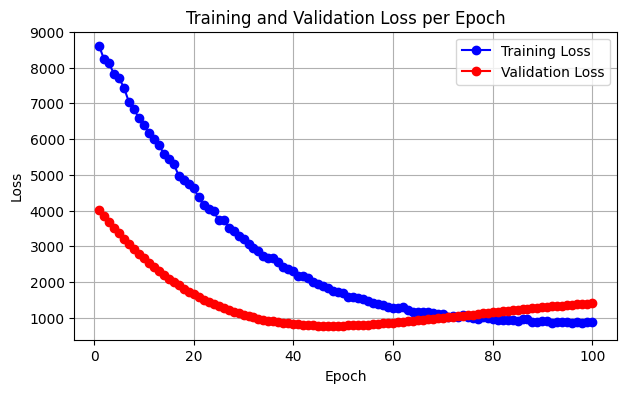

Test set: Average loss: 111.1937


In [19]:
model1 = CNNLSTM(kernel=3, num_filters=64, num_in_channels=4, lstm_hidden_size=128, lstm_layers=1).to(device)
epochs = 100
optimizer = torch.optim.Adam(model1.parameters(), lr=0.01, amsgrad=True)
criterion = nn.MSELoss()

train(model1, train_loader, val_loader, test_loader, criterion, optimizer, epochs)

# SOCNN

In [24]:
# Define the Offset Network (Multilayer Perceptron)
class OffsetNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(OffsetNetwork, self).__init__()
        # You can adjust the architecture as needed
        self.fc1 = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return x

# Define the Significance Network (Fully Convolutional Network)
class SignificanceNetwork(nn.Module):
    def __init__(self, channels, kernel_size=3):
        super(SignificanceNetwork, self).__init__()
        # Adjust the number of layers, kernel size as required
        self.conv1 = nn.Conv1d(channels, channels, kernel_size, padding=kernel_size//2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        return x

# Define the SOCNN Model
class SOCNN(nn.Module):
    def __init__(self, input_dim, output_dim, time_steps, channels):
        super(SOCNN, self).__init__()
        self.time_steps = time_steps
        self.significance_network = SignificanceNetwork(channels)
        self.offset_network = OffsetNetwork(input_dim, output_dim)
        self.W = nn.Parameter(torch.randn(output_dim, time_steps))

    def forward(self, x):
        significance = self.significance_network(x)
        offsets = torch.stack([self.offset_network(x[:, :, i]) for i in range(self.time_steps)], dim=2)
        print(self.W.shape)
        print(offsets.shape)
        print(significance.shape)
        y_hat = torch.sum(self.W * offsets * significance, dim=2)
        return y_hat

In [25]:
# Example usage
input_dim = 4
output_dim = 1054

model2 = SOCNN(input_dim, output_dim, time_steps=3, channels=4).to(device)

epochs = 500
# model2 = CNN(kernel=3, num_filters=64, num_in_channels=4).to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001, amsgrad=True)
criterion = nn.MSELoss()

train(model2, train_loader, val_loader, test_loader, criterion, optimizer, epochs)

torch.Size([1054, 3])
torch.Size([32, 1054, 3])
torch.Size([32, 4, 1470])


RuntimeError: The size of tensor a (3) must match the size of tensor b (1470) at non-singleton dimension 2